Task 1: Manual code for forward pass and backward pass

In [5]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
train_dataset=datasets.MNIST(root="./data",train=True,download=True,transform=transforms.ToTensor())
test_dataset=datasets.MNIST(root="./data",train=False,download=True,transform=transforms.ToTensor())
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from google.colab import drive
drive.mount('/content/drive')

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.53MB/s]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))
def relu(x):
  return torch.max(x,torch.tensor([0]))
def tanh(x):
  return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))
def softmax(x):
  return torch.exp(x)/torch.sum(torch.exp(x),dim=0)
def der_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))
def der_relu(x):
  return (x > 0).float()
def der_tanh(x):
  return 1-tanh(x)**2

In [73]:
# forward pass
class hand_network():
  def __init__(self,input_dim,hidden_layer_1,hidden_layer_2,hidden_layer_3,output,activation_function):
    self.w1=torch.rand(hidden_layer_1,input_dim)*2*((6.0/(input_dim+hidden_layer_1))**0.5)-(6.0/(input_dim+hidden_layer_1))**0.5
    self.w2=torch.rand(hidden_layer_2,hidden_layer_1)*2*((6.0/(hidden_layer_1+hidden_layer_2))**0.5)-(6/(hidden_layer_1+hidden_layer_2))**0.5
    self.w3=torch.rand(hidden_layer_3,hidden_layer_2)*2*((6.0/(hidden_layer_2+hidden_layer_3))**0.5)-(6/(hidden_layer_2+hidden_layer_3))**0.5
    self.w4=torch.rand(output,hidden_layer_3)*2*((6.0/(hidden_layer_3+output))**0.5)-(6.0/(hidden_layer_3+output))**0.5
    self.b1=torch.zeros(hidden_layer_1,1)
    self.b2=torch.zeros(hidden_layer_2,1)
    self.b3=torch.zeros(hidden_layer_3,1)
    self.b4=torch.zeros(output,1)
    self.act=activation_function
    self.out_act=softmax

  def forward_pass(self,x):
    self.layer_1_output=torch.matmul(self.w1,x)+self.b1
    self.layer_1_ac_output=self.act(self.layer_1_output)
    self.layer_2_output=torch.matmul(self.w2,self.layer_1_ac_output)+self.b2
    self.layer_2_ac_output=self.act(self.layer_2_output)
    self.layer_3_output=torch.matmul(self.w3,self.layer_2_ac_output)+self.b3
    self.layer_3_ac_output=self.act(self.layer_3_output)
    self.layer_4_output=torch.matmul(self.w4,self.layer_3_ac_output)+self.b4
    self.layer_4_ac_output=self.out_act(self.layer_4_output)
    self.one_hot_rep_output=torch.zeros(self.layer_4_ac_output.shape)
    for i,data in enumerate(self.layer_4_ac_output):
      self.one_hot_rep_output[i][torch.argmax(data)]=1
    self.result=torch.argmax(self.layer_4_ac_output,dim=0)
    return self.layer_4_ac_output,self.result,self.one_hot_rep_output



In [7]:
#dataset with one hot encoding
new_train_dataset=[]
for data in train_dataset:
  data_1=data[0].squeeze(0)
  one_hot=torch.zeros(10)
  one_hot[data[1]]=1
  new_train_dataset.append((data_1,one_hot))

In [8]:
train_loader=DataLoader(new_train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

In [9]:
print(len(new_train_dataset))

60000


In [19]:
def loss_fn(y,p):
  eps=1e-7
  loss=-torch.sum(y*torch.log(p+eps))/y.shape[0]
  # if torch.isnan(loss):
  #   print(y)
  #   print(p)
  #   print(torch.log(p))
  return loss

In [85]:
def training_loop_sigmoid(model,train_loader,test_loader,epochs,lr):
  train_loss=[]
  test_acc=[]
  test_loss=[]
  for i in range(epochs):
    correct=0
    total=0
    runn_loss=0
    for data in train_loader:
      x,y=data[0],data[1]
      x=x.reshape(x.shape[0],784)
      x=x.T
      # print(model.b1.shape)
      # print(torch.matmul(model.w1,x).shape)
      # print(y.shape)
      output,_,_=model.forward_pass(x)
      output=output.T
      loss=loss_fn(y,output)
      runn_loss+=loss.item()
      delta_4=output-y
      delta_3=torch.matmul(delta_4,model.w4)*(model.layer_3_ac_output.T)*(1-model.layer_3_ac_output.T)
      delta_2=torch.matmul(delta_3,model.w3)*(model.layer_2_ac_output.T)*(1-model.layer_2_ac_output.T)
      delta_1=torch.matmul(delta_2,model.w2)*(model.layer_1_ac_output.T)*(1-model.layer_1_ac_output.T)
      # for i in range(y.shape[0]):
      #   delta_3[i]=torch.matmul(delta_4[i],model.w4)*(torch.exp(-model.layer_3_output)).T[i]*(1/((1+torch.exp(-model.layer_3_output))**2).T[i])
      # print(delta_4.shape)
      # print(delta_3.shape)
      # print(delta_2.shape)
      # print(delta_1.shape)
      model.w1=model.w1-lr*torch.matmul(delta_1.T,x.T)
      model.w2=model.w2-lr*torch.matmul(delta_2.T,model.layer_1_ac_output.T)
      model.w3=model.w3-lr*torch.matmul(delta_3.T,model.layer_2_ac_output.T)
      model.w4=model.w4-lr*torch.matmul(delta_4.T,model.layer_3_ac_output.T)
      # print(delta_1.T.mean(dim=1).shape)
      model.b1=model.b1-lr*delta_1.T.mean(dim=1).reshape(model.b1.shape)
      model.b2=model.b2-lr*delta_2.T.mean(dim=1).reshape(model.b2.shape)
      model.b3=model.b3-lr*delta_3.T.mean(dim=1).reshape(model.b3.shape)
      model.b4=model.b4-lr*delta_4.T.mean(dim=1).reshape(model.b4.shape)
    train_loss.append(runn_loss/len(train_loader))
    test_loss_val=0
    for test_data in test_loader:
      x_test,y_test=test_data
      x_test=x_test.reshape(x_test.shape[0],784)
      x_test=x_test.T
      y_test=y_test.reshape(y_test.shape[0],1)
      val_result,result,_=model.forward_pass(x_test)
      val_result=val_result.T
      for j in range(y_test.shape[0]):
        test_loss_val+=-torch.log(val_result[j][y_test[j].item()])
        if result[j].item() == y_test[j].item():
          correct+=1
      total+=y_test.shape[0]
    test_acc.append(correct/total)
    test_loss.append(test_loss_val/total)
    print(f'Epoch [{i+1}/{epochs}], train_Loss: {train_loss[i]} , test_acc: {correct/total}, test_loss: {test_loss[i]} ')
  return train_loss,test_acc,test_loss


In [86]:
  hand_model_sigmoid=hand_network(784,500,250,100,10,sigmoid)
  epochs=15
  n=0.01
  train_loss,test_acc,test_loss=training_loop_sigmoid(hand_model_sigmoid,train_loader,test_loader,epochs,0.01)

Epoch [1/15], train_Loss: 0.9304670484176577 , test_acc: 0.892, test_loss: 0.35451439023017883 
Epoch [2/15], train_Loss: 0.30909573700604664 , test_acc: 0.92, test_loss: 0.25518175959587097 
Epoch [3/15], train_Loss: 0.22569719962934567 , test_acc: 0.9399, test_loss: 0.19671058654785156 
Epoch [4/15], train_Loss: 0.17643207698059615 , test_acc: 0.9498, test_loss: 0.15914525091648102 
Epoch [5/15], train_Loss: 0.14356709632879572 , test_acc: 0.9569, test_loss: 0.14025060832500458 
Epoch [6/15], train_Loss: 0.1213627538588176 , test_acc: 0.9616, test_loss: 0.12394356727600098 
Epoch [7/15], train_Loss: 0.10347983197195888 , test_acc: 0.9594, test_loss: 0.13030192255973816 
Epoch [8/15], train_Loss: 0.08943464695366779 , test_acc: 0.9684, test_loss: 0.1012841984629631 
Epoch [9/15], train_Loss: 0.07906118924044438 , test_acc: 0.9701, test_loss: 0.09942213445901871 
Epoch [10/15], train_Loss: 0.0701833017334751 , test_acc: 0.9734, test_loss: 0.08513518422842026 
Epoch [11/15], train_Loss:

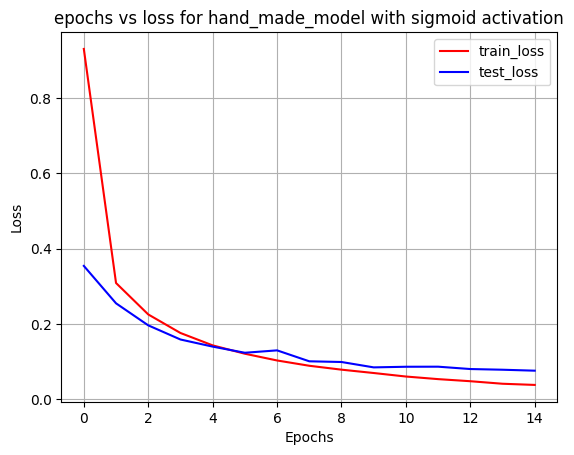

In [87]:
import matplotlib.pyplot as plt
plt.plot(range(15),train_loss,c="r",label="train_loss")
plt.plot(range(15),test_loss,c="b",label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.title("epochs vs loss for hand_made_model with sigmoid activation")
plt.legend()
plt.show()

tensor([7])
tensor([2])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([9])
tensor([5])
tensor([9])


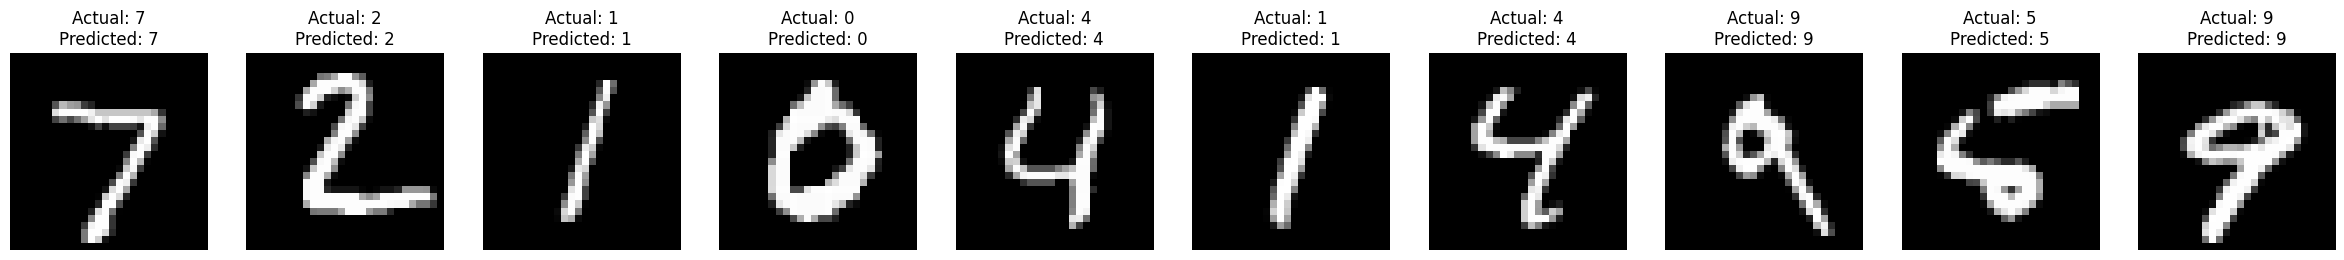

In [89]:
plt.figure(figsize=(30, 3))
for i in range(10):
  img,actual_value=test_dataset[i]
  _,predicted_value,_=hand_model_sigmoid.forward_pass(img.reshape(784,1))
  print(predicted_value)
  plt.subplot(1, 10, i + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Actual: {actual_value}\nPredicted: {predicted_value.item()}")
  plt.axis('off')

In [90]:
hand_param={"w1":hand_model_sigmoid.w1,"w2":hand_model_sigmoid.w2,"w3":hand_model_sigmoid.w3,"w4":hand_model_sigmoid.w4,"b1":hand_model_sigmoid.b1,"b2":hand_model_sigmoid.b2,"b3":hand_model_sigmoid.b3,"b4":hand_model_sigmoid.b4}

In [91]:
save_path="/content/drive/MyDrive/hand_model_sigmoid"
torch.save(hand_param, save_path)

In [92]:
path="/content/drive/MyDrive/hand_model_sigmoid"
hand_load_model=hand_network(784,500,250,100,10,sigmoid)
params=torch.load(path)
hand_load_model.w1=params["w1"]
hand_load_model.w2=params["w2"]
hand_load_model.w3=params["w3"]
hand_load_model.w4=params["w4"]
hand_load_model.b1=params["b1"]
hand_load_model.b2=params["b2"]
hand_load_model.b3=params["b3"]
hand_load_model.b4=params["b4"]


In [93]:
def generate_confusion_matrix_test(hand_load_model,test_loader):
  confusion_matrix=torch.zeros(10,10)
  correct=0
  total=0
  for test_data in test_loader:
      x_test,y_test=test_data
      x_test=x_test.reshape(x_test.shape[0],784)
      x_test=x_test.T
      y_test=y_test.reshape(y_test.shape[0],1)
      _,result,_=hand_load_model.forward_pass(x_test)
      for j in range(y_test.shape[0]):
        if result[j].item() == y_test[j].item():
          correct+=1
          confusion_matrix[y_test[j].item()][y_test[j].item()]+=1
        else:
          confusion_matrix[y_test[j].item()][result[j].item()]+=1
      total+=y_test.shape[0]
  return confusion_matrix,correct/total

In [94]:
import numpy as np
confusion_matrix,acc=generate_confusion_matrix_test(hand_load_model,test_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of test_data using sigmoid {acc*100}")

[[ 970.    0.    2.    0.    1.    4.    1.    1.    1.    0.]
 [   0. 1121.    7.    2.    0.    1.    2.    1.    1.    0.]
 [   3.    0. 1015.    4.    1.    0.    0.    4.    5.    0.]
 [   0.    0.    4.  990.    0.    5.    0.    4.    5.    2.]
 [   1.    0.    2.    1.  957.    1.    4.    3.    3.   10.]
 [   3.    0.    0.    3.    2.  878.    2.    0.    2.    2.]
 [   6.    3.    2.    1.    6.    7.  929.    0.    4.    0.]
 [   1.    3.   13.    4.    1.    1.    0.  998.    3.    4.]
 [   3.    0.    4.    3.    1.    3.    2.    2.  955.    1.]
 [   5.    4.    1.    9.   15.    9.    0.    5.    8.  953.]]
accuracy of test_data using sigmoid 97.66


In [95]:
def generate_confusion_matrix_train(hand_load_model,train_loader):
  confusion_matrix=torch.zeros(10,10)
  correct=0
  total=0
  for data in train_loader:
      x_train,y_train=data
      x_train=x_train.reshape(x_train.shape[0],784)
      x_train=x_train.T
      y_train=y_train.reshape(y_train.shape[0],10)
      _,result,_=hand_load_model.forward_pass(x_train)
      for j in range(y_train.shape[0]):
        if result[j].item() == torch.argmax(y_train[j]).item():
          correct+=1
          confusion_matrix[result[j].item()][result[j].item()]+=1
        else:
          confusion_matrix[torch.argmax(y_train[j]).item()][result[j].item()]+=1
      total+=y_train.shape[0]
  return confusion_matrix,correct/total

In [96]:
confusion_matrix,acc=generate_confusion_matrix_train(hand_load_model,train_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of train_data using sigmoid {acc*100}")

[[5911.    0.    5.    0.    0.    1.    0.    1.    2.    3.]
 [   1. 6694.   19.    7.    3.    1.    3.   13.    1.    0.]
 [   3.    2. 5936.    3.    3.    1.    1.    7.    2.    0.]
 [   1.    0.   10. 6077.    0.   26.    0.    4.   10.    3.]
 [   5.    1.    7.    0. 5807.    2.    4.    3.    5.    8.]
 [   2.    0.    1.   10.    0. 5401.    5.    1.    1.    0.]
 [  26.    1.    5.    0.    8.   16. 5859.    0.    3.    0.]
 [   2.    5.   26.    2.    6.    2.    0. 6219.    1.    2.]
 [   6.    5.    6.    6.    0.    4.    3.    1. 5817.    3.]
 [  13.    1.    1.   15.   58.   49.    0.   28.   15. 5769.]]
accuracy of train_data using sigmoid 99.15


2. Using Relu as activation

In [97]:
def training_loop_relu(model,train_loader,test_loader,epochs,lr):
  train_loss=[]
  test_acc=[]
  test_loss=[]
  for i in range(epochs):
    correct=0
    total=0
    runn_loss=0
    for data in train_loader:
      x,y=data[0],data[1]
      x=x.reshape(x.shape[0],784)
      x=x.T
      # print(model.b1.shape)
      # print(torch.matmul(model.w1,x).shape)
      # print(y.shape)
      output,_,_=model.forward_pass(x)
      output=output.T
      loss=loss_fn(y,output)

      runn_loss+=loss.item()
      delta_4=output-y
      delta_3=torch.matmul(delta_4,model.w4)*(der_relu(model.layer_3_output.T))
      delta_2=torch.matmul(delta_3,model.w3)*(der_relu(model.layer_2_output.T))
      delta_1=torch.matmul(delta_2,model.w2)*(der_relu(model.layer_1_output.T))
      # for i in range(y.shape[0]):
      #   delta_3[i]=torch.matmul(delta_4[i],model.w4)*(torch.exp(-model.layer_3_output)).T[i]*(1/((1+torch.exp(-model.layer_3_output))**2).T[i])
      # print(delta_4.shape)
      # print(delta_3.shape)
      # print(delta_2.shape)
      # print(delta_1.shape)
      model.w1=model.w1-lr*torch.matmul(delta_1.T,x.T)
      model.w2=model.w2-lr*torch.matmul(delta_2.T,model.layer_1_ac_output.T)
      model.w3=model.w3-lr*torch.matmul(delta_3.T,model.layer_2_ac_output.T)
      model.w4=model.w4-lr*torch.matmul(delta_4.T,model.layer_3_ac_output.T)
      # print(delta_1.T.mean(dim=1).shape)
      model.b1=model.b1-lr*delta_1.T.mean(dim=1).reshape(model.b1.shape)
      model.b2=model.b2-lr*delta_2.T.mean(dim=1).reshape(model.b2.shape)
      model.b3=model.b3-lr*delta_3.T.mean(dim=1).reshape(model.b3.shape)
      model.b4=model.b4-lr*delta_4.T.mean(dim=1).reshape(model.b4.shape)
    train_loss.append(runn_loss/len(train_loader))
    test_loss_val=0
    for test_data in test_loader:
      x_test,y_test=test_data
      x_test=x_test.reshape(x_test.shape[0],784)
      x_test=x_test.T
      y_test=y_test.reshape(y_test.shape[0],1)
      val_result,result,_=model.forward_pass(x_test)
      val_result=val_result.T
      for j in range(y_test.shape[0]):
        test_loss_val+=-torch.log(val_result[j][y_test[j].item()])
        if result[j].item() == y_test[j].item():
          correct+=1
      total+=y_test.shape[0]
    test_loss.append(test_loss_val/total)
    print(f'Epoch [{i+1}/{epochs}], train_Loss: {train_loss[i]} , test_acc: {correct/total}, test_loss: {test_loss[i]} ')
  return train_loss,test_acc,test_loss

In [100]:
  hand_model_relu=hand_network(784,500,250,100,10,relu)
  epochs=15
  n=0.01
  train_loss,test_acc,test_loss=training_loop_relu(hand_model_relu,train_loader,test_loader,epochs,0.01)

Epoch [1/15], train_Loss: 0.2973913132756162 , test_acc: 0.957, test_loss: 0.14293062686920166 
Epoch [2/15], train_Loss: 0.10726802326145092 , test_acc: 0.9591, test_loss: 0.12418217957019806 
Epoch [3/15], train_Loss: 0.06916286049697147 , test_acc: 0.9746, test_loss: 0.08363868296146393 
Epoch [4/15], train_Loss: 0.053792993725984416 , test_acc: 0.9763, test_loss: 0.08446674793958664 
Epoch [5/15], train_Loss: 0.042069826356821265 , test_acc: 0.9788, test_loss: 0.07500720769166946 
Epoch [6/15], train_Loss: 0.03242176107118782 , test_acc: 0.9791, test_loss: 0.08363514393568039 
Epoch [7/15], train_Loss: 0.02775084805611679 , test_acc: 0.9804, test_loss: 0.07601866126060486 
Epoch [8/15], train_Loss: 0.02398440495960028 , test_acc: 0.9746, test_loss: 0.1035461574792862 
Epoch [9/15], train_Loss: 0.022460525226829314 , test_acc: 0.9716, test_loss: 0.11693689972162247 
Epoch [10/15], train_Loss: 0.018669086343174046 , test_acc: 0.9824, test_loss: 0.07395844161510468 
Epoch [11/15], tra

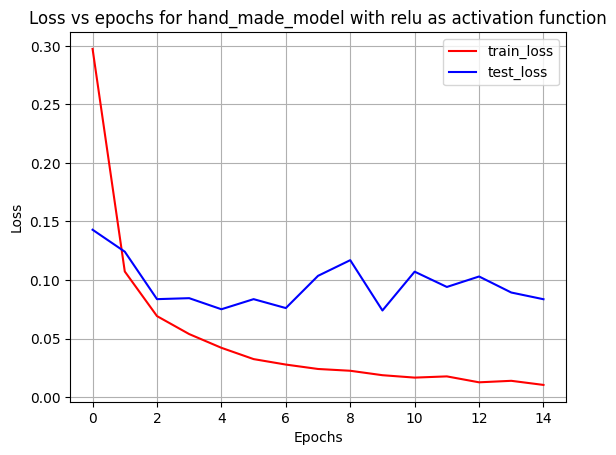

In [101]:
import matplotlib.pyplot as plt
plt.plot(range(15),train_loss,c="r",label="train_loss")
plt.plot(range(15),test_loss,c="b",label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs epochs for hand_made_model with relu as activation function")
plt.grid(True)
plt.legend()
plt.show()

tensor([7])
tensor([2])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([9])
tensor([5])
tensor([9])


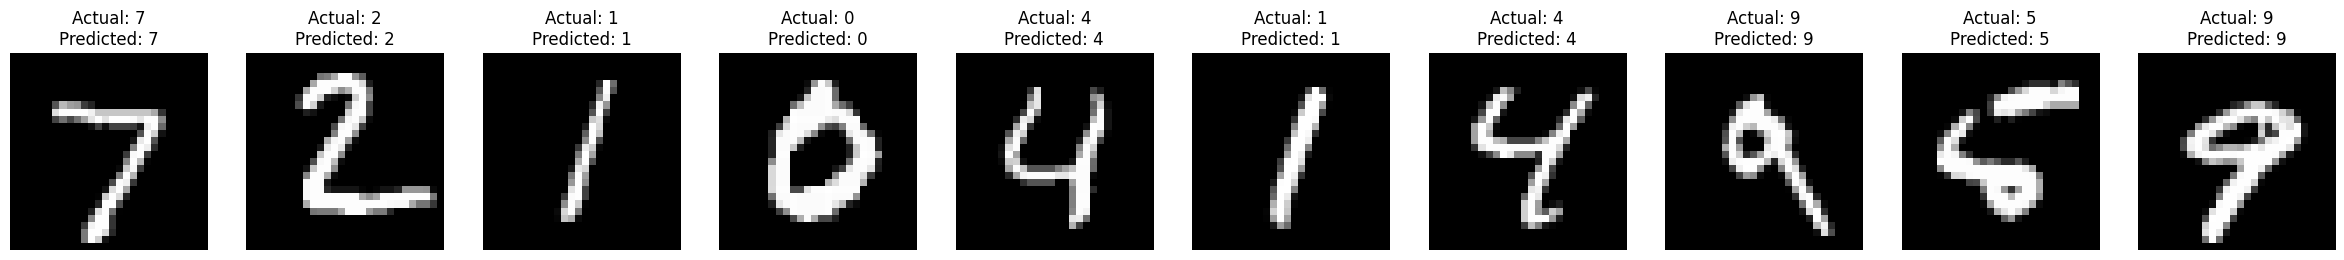

In [102]:
plt.figure(figsize=(30, 3))
for i in range(10):
  img,actual_value=test_dataset[i]
  _,predicted_value,_=hand_model_relu.forward_pass(img.reshape(784,1))
  print(predicted_value)
  plt.subplot(1, 10, i + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Actual: {actual_value}\nPredicted: {predicted_value.item()}")
  plt.axis('off')

In [103]:
import numpy as np
confusion_matrix,acc=generate_confusion_matrix_test(hand_model_relu,test_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of test_data using relu {acc*100}")

[[ 967.    1.    0.    1.    1.    1.    6.    1.    1.    1.]
 [   0. 1127.    2.    0.    0.    1.    2.    2.    1.    0.]
 [   2.    1. 1014.    3.    3.    1.    1.    4.    3.    0.]
 [   0.    0.    5.  990.    0.    3.    0.    4.    4.    4.]
 [   0.    2.    0.    0.  967.    0.    5.    2.    0.    6.]
 [   2.    0.    0.   10.    0.  872.    1.    1.    3.    3.]
 [   3.    3.    0.    1.    3.    8.  937.    0.    3.    0.]
 [   0.    2.    8.    1.    1.    0.    0. 1010.    1.    5.]
 [   1.    1.    1.    4.    1.    5.    1.    2.  956.    2.]
 [   1.    2.    0.    1.    6.    1.    1.    6.    2.  989.]]
accuracy of test_data using relu 98.29


In [104]:
confusion_matrix,acc=generate_confusion_matrix_train(hand_model_relu,train_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of train_data using relu {acc*100}")

[[5893.    0.    1.    0.    0.    3.   24.    1.    1.    0.]
 [   0. 6738.    2.    0.    0.    0.    0.    2.    0.    0.]
 [   0.    0. 5948.    1.    3.    0.    1.    1.    4.    0.]
 [   0.    0.    0. 6120.    0.    5.    0.    0.    3.    3.]
 [   0.    2.    0.    0. 5837.    0.    1.    1.    1.    0.]
 [   0.    0.    0.    3.    0. 5418.    0.    0.    0.    0.]
 [   0.    5.    3.    0.    0.   17. 5889.    0.    4.    0.]
 [   0.    3.    0.    0.    1.    0.    0. 6259.    0.    2.]
 [   0.    2.    1.    1.    0.   14.    0.    0. 5833.    0.]
 [   0.    0.    0.    0.    7.    0.    0.    4.    4. 5934.]]
accuracy of train_data using relu 99.78166666666667


3.Using tanh as activation

In [108]:
def training_loop_tanh(model,train_loader,test_loader,epochs,lr):
  test_loss=[]
  train_loss=[]
  test_acc=[]
  for i in range(epochs):
    correct=0
    total=0
    runn_loss=0
    for data in train_loader:
      x,y=data[0],data[1]
      x=x.reshape(x.shape[0],784)
      x=x.T
      output,_,_=model.forward_pass(x)
      output=output.T
      loss=loss_fn(y,output)
      runn_loss+=loss.item()
      delta_4=output-y
      delta_3=torch.matmul(delta_4,model.w4)*(der_tanh(model.layer_3_output.T))
      delta_2=torch.matmul(delta_3,model.w3)*(der_tanh(model.layer_2_output.T))
      delta_1=torch.matmul(delta_2,model.w2)*(der_tanh(model.layer_1_output.T))

      model.w1=model.w1-lr*torch.matmul(delta_1.T,x.T)
      model.w2=model.w2-lr*torch.matmul(delta_2.T,model.layer_1_ac_output.T)
      model.w3=model.w3-lr*torch.matmul(delta_3.T,model.layer_2_ac_output.T)
      model.w4=model.w4-lr*torch.matmul(delta_4.T,model.layer_3_ac_output.T)
      # print(delta_1.T.mean(dim=1).shape)
      model.b1=model.b1-lr*delta_1.T.mean(dim=1).reshape(model.b1.shape)
      model.b2=model.b2-lr*delta_2.T.mean(dim=1).reshape(model.b2.shape)
      model.b3=model.b3-lr*delta_3.T.mean(dim=1).reshape(model.b3.shape)
      model.b4=model.b4-lr*delta_4.T.mean(dim=1).reshape(model.b4.shape)
    train_loss.append(runn_loss/len(train_loader))
    test_loss_val=0
    for test_data in test_loader:
      x_test,y_test=test_data
      x_test=x_test.reshape(x_test.shape[0],784)
      x_test=x_test.T
      y_test=y_test.reshape(y_test.shape[0],1)
      val_result,result,_=model.forward_pass(x_test)
      val_result=val_result.T
      for j in range(y_test.shape[0]):
        test_loss_val+=-torch.log(val_result[j][y_test[j].item()]+1e-7)
        if result[j].item() == y_test[j].item():
          correct+=1
      total+=y_test.shape[0]
    test_loss.append(test_loss_val/total)
    print(f'Epoch [{i+1}/{epochs}], train_Loss: {train_loss[i]} , test_acc: {correct/total}, test_loss: {test_loss[i]} ')
  return train_loss,test_acc,test_loss

In [109]:
  hand_model_tanh=hand_network(784,500,250,100,10,tanh)
  epochs=15
  n=0.01
  train_loss,test_acc,test_loss=training_loop_tanh(hand_model_tanh,train_loader,test_loader,epochs,0.01)

Epoch [1/15], train_Loss: 0.970053078570981 , test_acc: 0.937, test_loss: 0.21826450526714325 
Epoch [2/15], train_Loss: 0.18847140802273046 , test_acc: 0.9529, test_loss: 0.16094304621219635 
Epoch [3/15], train_Loss: 0.13637853729755067 , test_acc: 0.9624, test_loss: 0.1357092410326004 
Epoch [4/15], train_Loss: 0.10227910689721659 , test_acc: 0.9572, test_loss: 0.14594240486621857 
Epoch [5/15], train_Loss: 0.08513366093294127 , test_acc: 0.9667, test_loss: 0.11668404191732407 
Epoch [6/15], train_Loss: 0.07200185846036443 , test_acc: 0.9695, test_loss: 0.11376301199197769 
Epoch [7/15], train_Loss: 0.055425893835428515 , test_acc: 0.968, test_loss: 0.1129351556301117 
Epoch [8/15], train_Loss: 0.04535225620825908 , test_acc: 0.9727, test_loss: 0.10535168647766113 
Epoch [9/15], train_Loss: 0.036277195690593164 , test_acc: 0.9752, test_loss: 0.09358508139848709 
Epoch [10/15], train_Loss: 0.02903597684565193 , test_acc: 0.9733, test_loss: 0.10319551825523376 
Epoch [11/15], train_Lo

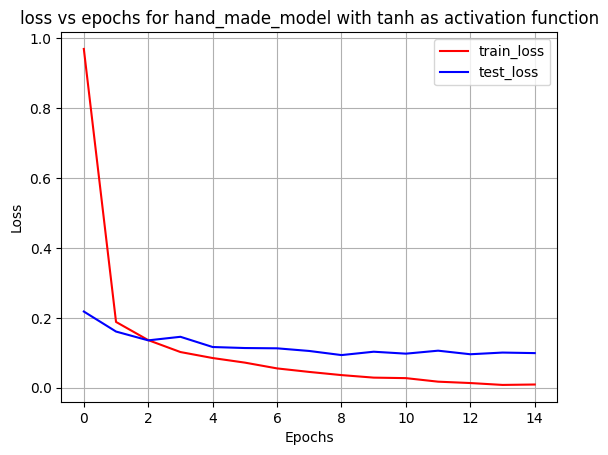

In [110]:
import matplotlib.pyplot as plt
plt.plot(range(15),train_loss,c="r",label="train_loss")
plt.plot(range(15),test_loss,c="b",label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epochs for hand_made_model with tanh as activation function")
plt.grid(True)
plt.legend()
plt.show()

tensor([7])
tensor([2])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([9])
tensor([5])
tensor([9])


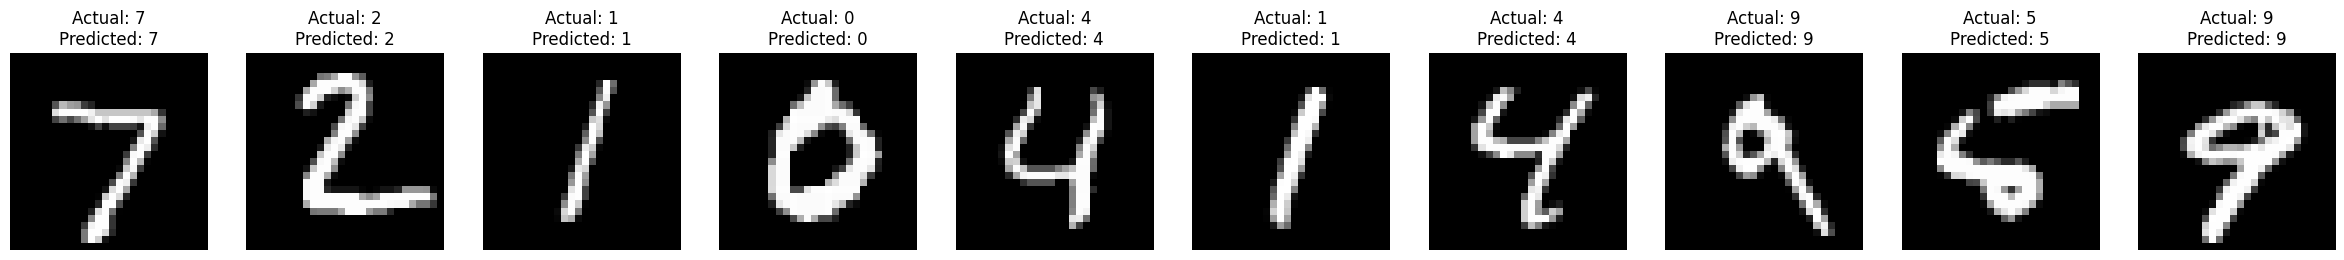

In [111]:
plt.figure(figsize=(30, 3))
for i in range(10):
  img,actual_value=test_dataset[i]
  _,predicted_value,_=hand_model_tanh.forward_pass(img.reshape(784,1))
  print(predicted_value)
  plt.subplot(1, 10, i + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Actual: {actual_value}\nPredicted: {predicted_value.item()}")
  plt.axis('off')

In [112]:
confusion_matrix,acc=generate_confusion_matrix_test(hand_model_tanh,test_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of test_data using tanh {acc*100}")

[[ 972.    0.    2.    0.    1.    1.    1.    1.    1.    1.]
 [   1. 1126.    1.    1.    0.    1.    2.    1.    2.    0.]
 [   3.    2. 1006.    6.    1.    0.    3.    5.    5.    1.]
 [   0.    0.    1.  996.    0.    3.    0.    4.    3.    3.]
 [   0.    1.    3.    0.  964.    0.    5.    2.    0.    7.]
 [   4.    0.    0.   13.    2.  858.    6.    1.    4.    4.]
 [   4.    2.    2.    1.    3.    2.  940.    0.    4.    0.]
 [   1.    5.    7.    8.    1.    0.    0.  998.    1.    7.]
 [   2.    0.    6.    8.    1.    8.    1.    3.  942.    3.]
 [   0.    4.    0.    4.   13.    1.    1.    8.    0.  978.]]
accuracy of test_data using tanh 97.8


In [113]:
confusion_matrix,acc=generate_confusion_matrix_train(hand_model_tanh,train_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of train_data using tanh {acc*100}")

[[5922.    0.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0. 6739.    0.    0.    2.    0.    0.    0.    1.    0.]
 [   0.    0. 5953.    3.    0.    0.    0.    1.    1.    0.]
 [   0.    0.    0. 6129.    0.    0.    0.    0.    2.    0.]
 [   0.    0.    2.    0. 5831.    0.    4.    2.    0.    3.]
 [   1.    0.    0.    1.    0. 5416.    3.    0.    0.    0.]
 [   1.    0.    0.    0.    0.    0. 5917.    0.    0.    0.]
 [   0.    8.    2.    3.    1.    0.    0. 6248.    0.    3.]
 [   1.    4.    1.    4.    0.    2.    1.    0. 5838.    0.]
 [   0.    4.    0.    3.   15.    0.    0.    5.    1. 5921.]]
accuracy of train_data using tanh 99.85666666666667


Relu activation function performs the best when compared to sigmoid and tanh

Problem 4 : creating MLP using pytorch library

In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from google.colab import drive
drive.mount('/content/drive')
import torch.nn as nn
import os

Mounted at /content/drive


In [115]:
class network(nn.Module):
  def __init__(self,input_dim=784,hid_1=500,hid_2=250,hid_3=100,out=10):
    super().__init__()
    self.layer_1=nn.Linear(input_dim,hid_1)
    self.act=nn.Sigmoid()
    self.out_act=nn.Softmax()
    self.layer_2=nn.Linear(hid_1,hid_2)
    self.layer_3=nn.Linear(hid_2,hid_3)
    self.out=nn.Linear(hid_3,out)

  def forward(self,x):
    out_1=self.act(self.layer_1(x))
    out_2=self.act(self.layer_2(out_1))
    out_3=self.act(self.layer_3(out_2))
    real_out=self.out_act(self.out(out_3))
    real_value=torch.argmax(real_out,dim=1)
    return real_out,real_value

In [117]:
def train_model(model,train_loader,test_loader,loss_fn,optimizer,epochs):
  train_loss=[]
  test_acc=[]
  test_loss=[]
  for i in range(epochs):
    model.train()
    runn_loss=0
    for data in train_loader:
      data[0]=data[0].reshape(len(data[0]),784)
      optimizer.zero_grad()
      prediction,_=model(data[0])
      loss=-torch.sum(torch.log(prediction)*data[1],dim=1)
      loss=loss.mean()
      runn_loss+=loss.item()
      loss.backward()
      optimizer.step()
    train_loss.append(runn_loss/len(train_loader))
    model.eval()
    correct=0
    total=0
    test_val_loss=0
    with torch.no_grad():
      for test_data in test_loader:
        test_data[0]=test_data[0].reshape(len(test_data[0]),784)
        real_out,prediction=model(test_data[0])
        for j in range(test_data[0].shape[0]):
          test_val_loss+=-torch.log(real_out[j][test_data[1][j].item()])
          if prediction[j].item() == test_data[1][j].item():
            correct+=1
        total+=test_data[0].shape[0]
      test_acc.append(correct/total)
      test_loss.append(test_val_loss/total)
    print(f'Epoch [{i+1}/{epochs}], train_Loss: {train_loss[i]}, test_acc: {test_acc[i]}, test_loss: {test_loss[i]}')
  return train_loss,test_acc,test_loss

In [119]:
model=network()
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
train_loss,test_acc,test_loss=train_model(model,train_loader,test_loader,loss_fn,optimizer,epochs=25)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/25], train_Loss: 0.2953312905120062, test_acc: 0.9622, test_loss: 0.13582780957221985
Epoch [2/25], train_Loss: 0.11952807266922441, test_acc: 0.9677, test_loss: 0.11089611798524857
Epoch [3/25], train_Loss: 0.10007646361287477, test_acc: 0.964, test_loss: 0.11705946177244186
Epoch [4/25], train_Loss: 0.08376102344376712, test_acc: 0.9627, test_loss: 0.12295734882354736
Epoch [5/25], train_Loss: 0.07880370134995607, test_acc: 0.9693, test_loss: 0.11144453287124634
Epoch [6/25], train_Loss: 0.07551967263021178, test_acc: 0.969, test_loss: 0.10998397320508957
Epoch [7/25], train_Loss: 0.07054081062331045, test_acc: 0.966, test_loss: 0.1154792457818985
Epoch [8/25], train_Loss: 0.06806222970216676, test_acc: 0.9697, test_loss: 0.10681157559156418
Epoch [9/25], train_Loss: 0.06630276207492422, test_acc: 0.9746, test_loss: 0.09215966612100601
Epoch [10/25], train_Loss: 0.06403395434236353, test_acc: 0.9732, test_loss: 0.10146181285381317
Epoch [11/25], train_Loss: 0.062137102342716

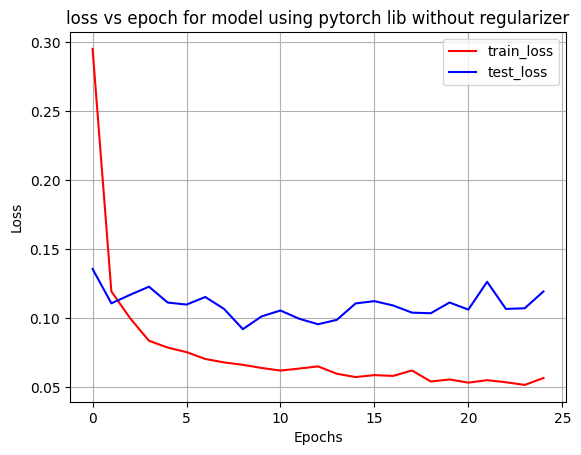

In [122]:
plt.plot(range(25),train_loss,c="r",label="train_loss")
plt.plot(range(25),test_loss,c="b",label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for model using pytorch lib without regularizer")
plt.grid(True)
plt.legend()
plt.show()

In [25]:
def generate_confusion_matrix_test(hand_load_model,test_loader):
  confusion_matrix=torch.zeros(10,10)
  correct=0
  total=0
  model.eval()
  with torch.no_grad():
    for test_data in test_loader:
      test_data[0]=test_data[0].reshape(len(test_data[0]),784)
      _,prediction=model(test_data[0])
      for j in range(test_data[0].shape[0]):
        if prediction[j].item() == test_data[1][j].item():
          correct+=1
          confusion_matrix[test_data[1][j].item()][test_data[1][j].item()]+=1
        else:
          confusion_matrix[test_data[1][j].item()][prediction[j].item()]+=1
      total+=test_data[0].shape[0]
  return confusion_matrix,correct/total

In [131]:
confusion_matrix,acc=generate_confusion_matrix_test(model,test_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of test_data using libraries without regularizer {acc*100}")

[[ 972.    1.    1.    1.    0.    0.    1.    2.    2.    0.]
 [   0. 1117.    5.    3.    2.    0.    3.    0.    5.    0.]
 [   8.    1. 1002.    4.    2.    0.    1.   12.    2.    0.]
 [   2.    0.   10.  976.    0.    5.    0.    7.    8.    2.]
 [   1.    0.    8.    0.  956.    0.    1.    2.    1.   13.]
 [   4.    0.    0.   14.    1.  857.    9.    1.    4.    2.]
 [   4.    2.    3.    1.    2.    5.  939.    0.    1.    1.]
 [   1.    3.    6.    2.    3.    0.    0. 1006.    0.    7.]
 [   9.    3.   13.    6.    3.    5.    7.    6.  917.    5.]
 [   5.    5.    1.    7.   16.    0.    0.    7.    6.  962.]]
accuracy of test_data using libraries without regularizer 97.04


In [24]:
def generate_confusion_matrix_train(hand_load_model,train_loader):
  confusion_matrix=torch.zeros(10,10)
  correct=0
  total=0
  model.eval()
  with torch.no_grad():
    for data in train_loader:
      x_train,y_train=data
      x_train=x_train.reshape(x_train.shape[0],784)
      y_train=y_train.reshape(y_train.shape[0],10)
      _,prediction=model(x_train)
      for j in range(y_train.shape[0]):
        if prediction[j].item() == torch.argmax(y_train[j]).item():
          correct+=1
          confusion_matrix[prediction[j].item()][prediction[j].item()]+=1
        else:
          confusion_matrix[torch.argmax(y_train[j]).item()][prediction[j].item()]+=1
      total+=y_train.shape[0]
  return confusion_matrix,correct/total

In [133]:
confusion_matrix,acc=generate_confusion_matrix_train(model,train_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of train_data using libraries without regularizer{acc*100}")

[[5904.    3.    8.    0.    0.    1.    2.    1.    3.    1.]
 [   1. 6690.   15.    7.   10.    0.    3.    2.    8.    6.]
 [  25.    6. 5884.    4.   11.    0.    5.   18.    3.    2.]
 [   4.    6.   55. 5981.    0.   16.    0.   17.   36.   16.]
 [   5.    4.    6.    0. 5805.    0.    1.    2.    1.   18.]
 [  12.    2.    3.   35.    2. 5293.   34.    4.   13.   23.]
 [  29.    0.    6.    0.    5.    4. 5870.    0.    4.    0.]
 [   1.   17.    5.    4.   15.    0.    0. 6202.    0.   21.]
 [  15.   49.   43.    8.    1.    6.   25.    5. 5690.    9.]
 [  11.    6.    2.   18.   59.    3.    0.   32.   27. 5791.]]
accuracy of train_data using libraries without regularizer98.51666666666667


tensor([7])
tensor([2])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([9])
tensor([6])
tensor([9])


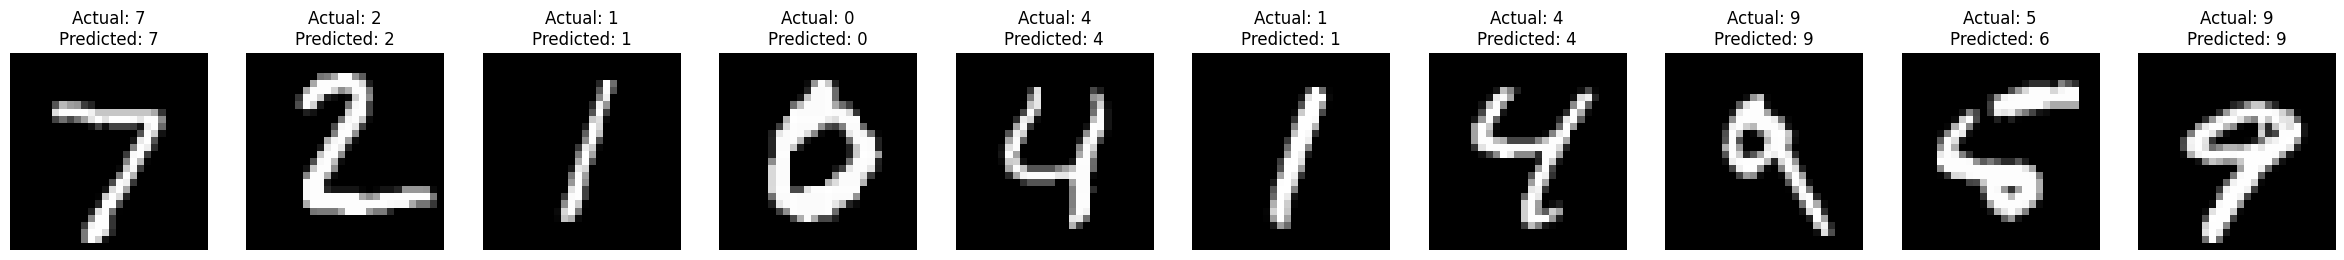

In [134]:
plt.figure(figsize=(30, 3))
for i in range(10):
  img,actual_value=test_dataset[i]
  _,predicted_value=model(img.reshape(1,784))
  print(predicted_value)
  plt.subplot(1, 10, i + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Actual: {actual_value}\nPredicted: {predicted_value.item()}")
  plt.axis('off')

Problem 4.1: Model using library with regularizer

In [135]:
def train_model_regularizer(model,train_loader,test_loader,loss_fn,optimizer,epochs,z=1e-5):
  train_loss=[]
  test_acc=[]
  test_loss=[]
  for i in range(epochs):
    model.train()
    runn_loss=0
    for data in train_loader:
      data[0]=data[0].reshape(len(data[0]),784)
      optimizer.zero_grad()
      prediction,_=model(data[0])
      loss=-torch.sum(torch.log(prediction)*data[1],dim=1)
      loss=loss.mean()
      runn_loss+=loss.item()
      sum_weights=torch.tensor(0.)
      for index,param in enumerate(model.parameters()):
        if index%2==0:
          sum_weights+=torch.sum(param.pow(2))
      loss+=z*sum_weights
      loss.backward()
      optimizer.step()
    train_loss.append(runn_loss/len(train_loader))
    model.eval()
    correct=0
    total=0
    test_val_loss=0
    with torch.no_grad():
      for test_data in test_loader:
        test_data[0]=test_data[0].reshape(len(test_data[0]),784)
        real_out,prediction=model(test_data[0])
        for j in range(test_data[0].shape[0]):
          test_val_loss+=-torch.log(real_out[j][test_data[1][j].item()])
          if prediction[j].item() == test_data[1][j].item():
            correct+=1
        total+=test_data[0].shape[0]
      test_acc.append(correct/total)
      test_loss.append(test_val_loss/total)
    print(f'Epoch [{i+1}/{epochs}], train_Loss: {train_loss[i]}, test_acc: {test_acc[i]}, test_loss: {test_loss[i]}')
  return train_loss,test_acc,test_loss

In [136]:
model=network()
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
train_loss,test_acc,test_loss=train_model_regularizer(model,train_loader,test_loader,loss_fn,optimizer,epochs=15)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/15], train_Loss: 0.32755340398676486, test_acc: 0.9518, test_loss: 0.15846118330955505
Epoch [2/15], train_Loss: 0.14402822494459178, test_acc: 0.9609, test_loss: 0.13274110853672028
Epoch [3/15], train_Loss: 0.12089664053851004, test_acc: 0.966, test_loss: 0.1079661026597023
Epoch [4/15], train_Loss: 0.11292806573198247, test_acc: 0.9583, test_loss: 0.13381707668304443
Epoch [5/15], train_Loss: 0.10443114639738443, test_acc: 0.9677, test_loss: 0.10762298852205276
Epoch [6/15], train_Loss: 0.10196523959520085, test_acc: 0.9655, test_loss: 0.11003317683935165
Epoch [7/15], train_Loss: 0.09859677061050344, test_acc: 0.9712, test_loss: 0.0953945443034172
Epoch [8/15], train_Loss: 0.09327012918510241, test_acc: 0.9701, test_loss: 0.09514673054218292
Epoch [9/15], train_Loss: 0.09159331496105964, test_acc: 0.9658, test_loss: 0.11170314997434616
Epoch [10/15], train_Loss: 0.09476178354059439, test_acc: 0.9658, test_loss: 0.10946915298700333
Epoch [11/15], train_Loss: 0.0838500200599

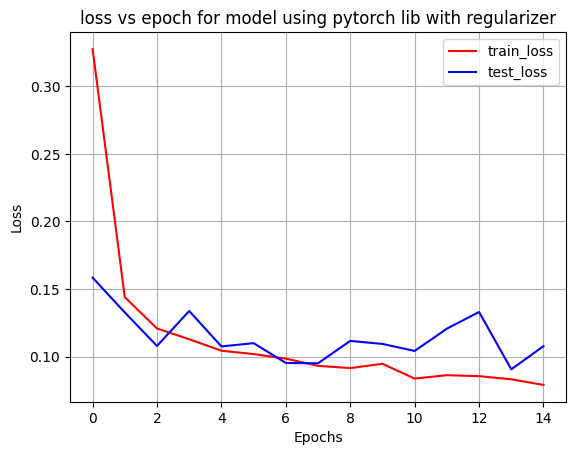

In [138]:
plt.plot(range(15),train_loss,c="r",label="train_loss")
plt.plot(range(15),test_loss,c="b",label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for model using pytorch lib with regularizer")
plt.grid(True)
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([7])
tensor([2])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([9])
tensor([5])
tensor([9])


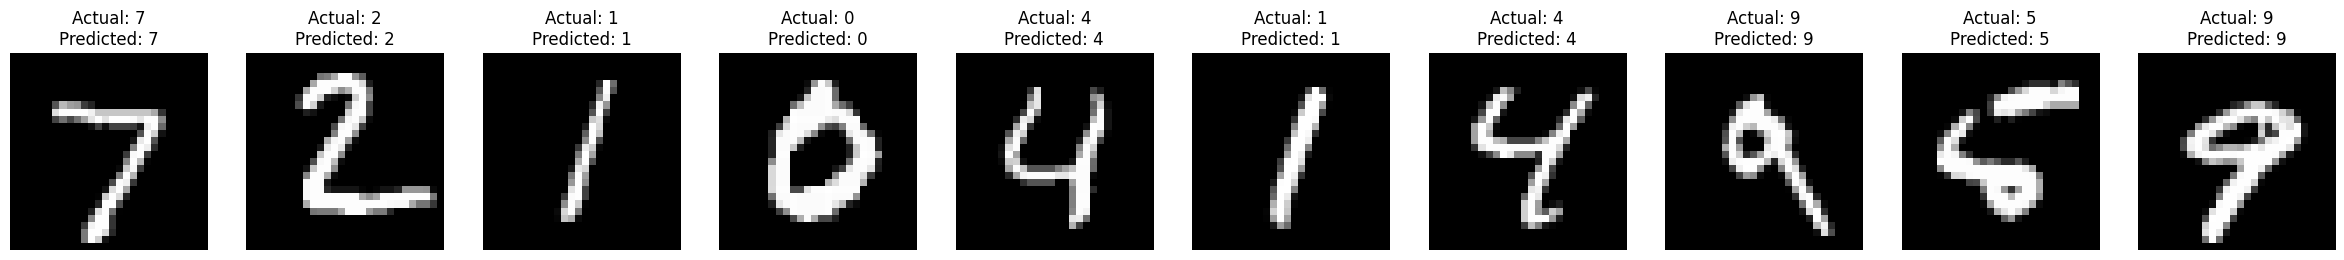

In [139]:
plt.figure(figsize=(30, 3))
for i in range(10):
  img,actual_value=test_dataset[i]
  _,predicted_value=model(img.reshape(1,784))
  print(predicted_value)
  plt.subplot(1, 10, i + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Actual: {actual_value}\nPredicted: {predicted_value.item()}")
  plt.axis('off')

In [140]:
import numpy as np
confusion_matrix,acc=generate_confusion_matrix_test(model,test_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of test_data using pytorch lib with regularizer {acc*100}")

[[ 972.    0.    0.    0.    1.    0.    2.    2.    3.    0.]
 [   0. 1125.    1.    2.    0.    0.    0.    1.    6.    0.]
 [   7.    0.  993.    9.    3.    2.    1.   10.    6.    1.]
 [   0.    0.    3.  984.    0.    4.    0.    8.    5.    6.]
 [   5.    0.    1.    0.  944.    0.    6.    4.    0.   22.]
 [   4.    1.    0.   25.    2.  839.    2.    3.    4.   12.]
 [  15.    3.    0.    1.    4.   13.  916.    0.    6.    0.]
 [   2.    3.    8.    0.    3.    0.    0. 1001.    0.   11.]
 [   3.    0.    2.    9.    5.    4.    2.    7.  925.   17.]
 [   3.    3.    0.    2.    7.    1.    0.    5.    0.  988.]]
accuracy of test_data using pytorch lib with regularizer 96.87


In [141]:
confusion_matrix,acc=generate_confusion_matrix_train(model,train_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of train_data using using pytorch lib with regularizer {acc*100}")

[[5868.    1.    1.    2.    4.    7.   10.    1.   16.   13.]
 [   0. 6681.    9.    1.    7.    0.    0.   23.   13.    8.]
 [  18.   12. 5788.   52.    8.    1.    3.   42.   25.    9.]
 [   4.    5.   17. 5975.    1.   19.    0.   36.   19.   55.]
 [   6.    4.    4.    3. 5696.    1.   12.   12.    2.  102.]
 [  14.    2.    2.  102.    5. 5165.    5.    6.   45.   75.]
 [  41.   23.   10.    0.   11.   59. 5756.    0.   17.    1.]
 [   2.    5.   10.    2.   11.    0.    0. 6191.    1.   43.]
 [  12.   15.    8.   45.   14.   15.    1.    7. 5606.  128.]
 [   5.    3.    1.   15.    8.   11.    1.   35.    4. 5866.]]
accuracy of train_data using using pytorch lib with regularizer 97.65333333333334


Building model using pytorch lib and relu as hidden layer activation

In [11]:
class network_1(nn.Module):
  def __init__(self,input_dim=784,hid_1=500,hid_2=250,hid_3=100,out=10):
    super().__init__()
    self.layer_1=nn.Linear(input_dim,hid_1)
    self.act=nn.ReLU()
    self.out_act=nn.Softmax()
    self.layer_2=nn.Linear(hid_1,hid_2)
    self.layer_3=nn.Linear(hid_2,hid_3)
    self.out=nn.Linear(hid_3,out)

  def forward(self,x):
    out_1=self.act(self.layer_1(x))
    out_2=self.act(self.layer_2(out_1))
    out_3=self.act(self.layer_3(out_2))
    real_out=self.out_act(self.out(out_3))
    real_value=torch.argmax(real_out,dim=1)
    return real_out,real_value

In [17]:
def train_model(model,train_loader,test_loader,loss_fn,optimizer,epochs):
  train_loss=[]
  test_acc=[]
  test_loss=[]
  for i in range(epochs):
    model.train()
    runn_loss=0
    for data in train_loader:
      data[0]=data[0].reshape(len(data[0]),784)
      optimizer.zero_grad()
      prediction,_=model(data[0])
      loss=-torch.sum(torch.log(prediction+1e-7)*data[1],dim=1)
      loss=loss.mean()
      runn_loss+=loss.item()
      loss.backward()
      optimizer.step()
    train_loss.append(runn_loss/len(train_loader))
    model.eval()
    correct=0
    total=0
    test_val_loss=0
    with torch.no_grad():
      for test_data in test_loader:
        test_data[0]=test_data[0].reshape(len(test_data[0]),784)
        real_out,prediction=model(test_data[0])
        for j in range(test_data[0].shape[0]):
          test_val_loss+=-torch.log(real_out[j][test_data[1][j].item()]+1e-7)
          if prediction[j].item() == test_data[1][j].item():
            correct+=1
        total+=test_data[0].shape[0]
      test_acc.append(correct/total)
      test_loss.append(test_val_loss/total)
    print(f'Epoch [{i+1}/{epochs}], train_Loss: {train_loss[i]}, test_acc: {test_acc[i]}, test_loss: {test_loss[i]}')
  return train_loss,test_acc,test_loss

In [18]:
model=network_1()
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
train_loss,test_acc,test_loss=train_model(model,train_loader,test_loader,loss_fn,optimizer,epochs=25)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/25], train_Loss: 0.28816513981181646, test_acc: 0.9535, test_loss: 0.1723804622888565
Epoch [2/25], train_Loss: 0.17110116101343678, test_acc: 0.9587, test_loss: 0.15977732837200165
Epoch [3/25], train_Loss: 0.1488430953785918, test_acc: 0.9604, test_loss: 0.18058817088603973
Epoch [4/25], train_Loss: 0.1384930900816343, test_acc: 0.9615, test_loss: 0.16317413747310638
Epoch [5/25], train_Loss: 0.11987012304722576, test_acc: 0.9641, test_loss: 0.15723547339439392
Epoch [6/25], train_Loss: 0.11502789675882623, test_acc: 0.9538, test_loss: 0.22394335269927979
Epoch [7/25], train_Loss: 0.11674691758876635, test_acc: 0.9703, test_loss: 0.13388395309448242
Epoch [8/25], train_Loss: 0.1087527096287401, test_acc: 0.963, test_loss: 0.16198426485061646
Epoch [9/25], train_Loss: 0.09966953644216352, test_acc: 0.9633, test_loss: 0.17404887080192566
Epoch [10/25], train_Loss: 0.11125836078757555, test_acc: 0.9648, test_loss: 0.17489735782146454
Epoch [11/25], train_Loss: 0.110922239548572

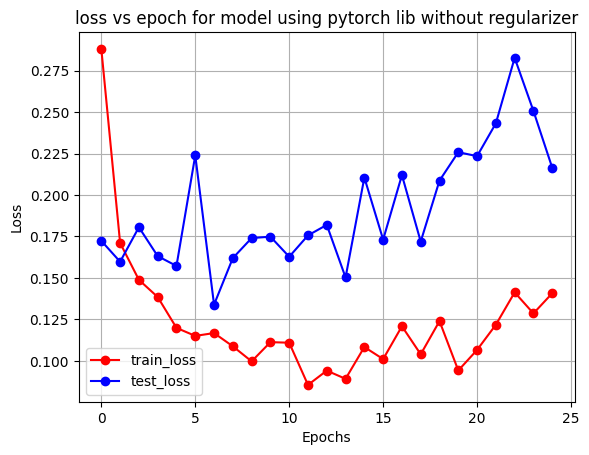

In [21]:
plt.plot(range(25),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(25),test_loss,c="b",marker="o",label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for model using pytorch lib without regularizer")
plt.grid(True)
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([7])
tensor([2])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([9])
tensor([6])
tensor([9])


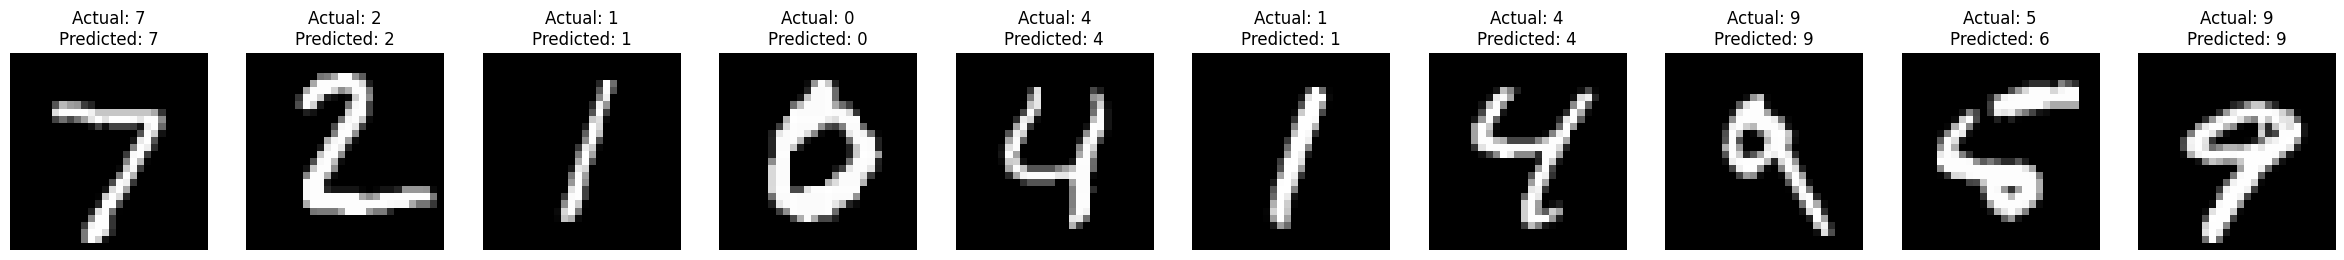

In [22]:
plt.figure(figsize=(30, 3))
for i in range(10):
  img,actual_value=test_dataset[i]
  _,predicted_value=model(img.reshape(1,784))
  print(predicted_value)
  plt.subplot(1, 10, i + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Actual: {actual_value}\nPredicted: {predicted_value.item()}")
  plt.axis('off')

In [29]:
import numpy as np
confusion_matrix,acc=generate_confusion_matrix_test(model,test_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of test_data using pytorch lib and relu activation without regularizer {acc*100}")

[[ 959.    0.   19.    0.    0.    1.    0.    1.    0.    0.]
 [   0. 1112.   11.    3.    0.    1.    1.    1.    6.    0.]
 [   1.    0. 1010.    6.    1.    0.    0.   10.    4.    0.]
 [   0.    0.    6.  993.    0.    1.    0.    2.    6.    2.]
 [   0.    0.   15.    0.  943.    0.    4.    2.    1.   17.]
 [   4.    0.   25.   17.    1.  820.    4.    1.   13.    7.]
 [   4.    1.   24.    0.    2.    2.  920.    0.    5.    0.]
 [   1.    0.   21.    3.    3.    1.    0.  987.    2.   10.]
 [   1.    0.   22.    6.    5.    2.    0.    2.  933.    3.]
 [   2.    2.    3.    5.    4.    2.    0.    6.    4.  981.]]
accuracy of test_data using pytorch lib and relu activation without regularizer 96.58


In [30]:
confusion_matrix,acc=generate_confusion_matrix_train(model,train_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of train_data using pytorch lib and relu without regularizer {acc*100}")

[[5771.    0.  141.    0.    0.    0.    3.    1.    4.    3.]
 [   0. 6654.   59.    4.    3.    0.    4.    3.    8.    7.]
 [   1.    1. 5918.   14.    1.    0.    0.   17.    6.    0.]
 [   0.    0.   59. 6024.    3.    7.    0.    7.   16.   15.]
 [   1.    0.   58.    0. 5693.    0.    4.    2.    1.   83.]
 [   7.    0.  120.   57.    0. 5179.   11.    0.   20.   27.]
 [   4.    0.  137.    0.    2.    4. 5756.    0.   15.    0.]
 [   1.    2.   66.   10.    6.    0.    0. 6157.    0.   23.]
 [   4.    7.   66.   16.    4.    9.    0.    2. 5730.   13.]
 [   4.    0.   16.   13.   14.    1.    0.   16.   12. 5873.]]
accuracy of train_data using pytorch lib and relu without regularizer 97.925


In [33]:
def train_model_regularizer(model,train_loader,test_loader,loss_fn,optimizer,epochs,z=1e-5):
  train_loss=[]
  test_acc=[]
  test_loss=[]
  for i in range(epochs):
    model.train()
    runn_loss=0
    for data in train_loader:
      data[0]=data[0].reshape(len(data[0]),784)
      optimizer.zero_grad()
      prediction,_=model(data[0])
      loss=-torch.sum(torch.log(prediction+1e-7)*data[1],dim=1)
      loss=loss.mean()
      runn_loss+=loss.item()
      sum_weights=torch.tensor(0.)
      for index,param in enumerate(model.parameters()):
        if index%2==0:
          sum_weights+=torch.sum(param.pow(2))
      loss+=z*sum_weights
      loss.backward()
      optimizer.step()
    train_loss.append(runn_loss/len(train_loader))
    model.eval()
    correct=0
    total=0
    test_val_loss=0
    with torch.no_grad():
      for test_data in test_loader:
        test_data[0]=test_data[0].reshape(len(test_data[0]),784)
        real_out,prediction=model(test_data[0])
        for j in range(test_data[0].shape[0]):
          test_val_loss+=-torch.log(real_out[j][test_data[1][j].item()]+1e-7)
          if prediction[j].item() == test_data[1][j].item():
            correct+=1
        total+=test_data[0].shape[0]
      test_acc.append(correct/total)
      test_loss.append(test_val_loss/total)
    print(f'Epoch [{i+1}/{epochs}], train_Loss: {train_loss[i]}, test_acc: {test_acc[i]}, test_loss: {test_loss[i]}')
  return train_loss,test_acc,test_loss

In [34]:
model=network_1()
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
train_loss,test_acc,test_loss=train_model_regularizer(model,train_loader,test_loader,loss_fn,optimizer,epochs=15)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/15], train_Loss: 0.28235834279258465, test_acc: 0.9489, test_loss: 0.1951228678226471
Epoch [2/15], train_Loss: 0.17200414317824853, test_acc: 0.9558, test_loss: 0.16659994423389435
Epoch [3/15], train_Loss: 0.1430871364703255, test_acc: 0.9671, test_loss: 0.13006912171840668
Epoch [4/15], train_Loss: 0.13863967569656113, test_acc: 0.963, test_loss: 0.16736020147800446
Epoch [5/15], train_Loss: 0.12559636930194396, test_acc: 0.9591, test_loss: 0.1715407818555832
Epoch [6/15], train_Loss: 0.12013623332763627, test_acc: 0.965, test_loss: 0.15617136657238007
Epoch [7/15], train_Loss: 0.11531585200775617, test_acc: 0.964, test_loss: 0.1428222358226776
Epoch [8/15], train_Loss: 0.1107286206756367, test_acc: 0.9657, test_loss: 0.1281892955303192
Epoch [9/15], train_Loss: 0.11029947231146894, test_acc: 0.9656, test_loss: 0.13908681273460388
Epoch [10/15], train_Loss: 0.10751333723077054, test_acc: 0.9608, test_loss: 0.1770131140947342
Epoch [11/15], train_Loss: 0.10514175113457352, t

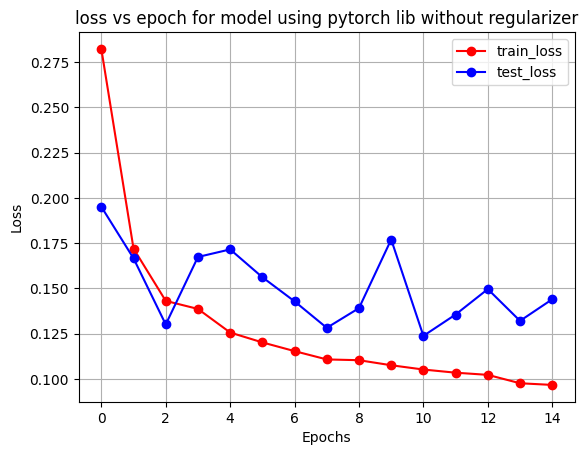

In [39]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),test_loss,c="b",marker="o",label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for model using pytorch lib without regularizer")
plt.grid(True)
plt.legend()
plt.show()

In [36]:
import numpy as np
confusion_matrix,acc=generate_confusion_matrix_test(model,test_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of test_data using pytorch lib and relu with regularizer {acc*100}")

[[ 975.    0.    1.    0.    0.    0.    1.    0.    2.    1.]
 [   0. 1112.   11.    3.    0.    0.    2.    0.    7.    0.]
 [   4.    0. 1019.    3.    0.    0.    2.    2.    2.    0.]
 [   0.    0.    7.  986.    0.    4.    0.    7.    4.    2.]
 [   1.    0.   15.    0.  925.    0.    7.    3.    6.   25.]
 [   6.    0.    2.   25.    0.  843.   10.    2.    4.    0.]
 [   5.    2.    4.    1.    3.    1.  940.    1.    1.    0.]
 [   3.    2.   27.    0.    2.    0.    0.  983.    3.    8.]
 [  15.    0.   16.    7.    3.   13.   13.    2.  904.    1.]
 [   4.    4.    1.    7.    4.   10.    2.   19.   19.  939.]]
accuracy of test_data using pytorch lib and relu with regularizer 96.26


In [37]:
confusion_matrix,acc=generate_confusion_matrix_train(model,train_loader)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
print(confusion_matrix.detach().numpy())
print(f"accuracy of train_data using pytorch lib and relu with regularizer {acc*100}")

[[5878.    0.    9.    5.    0.    3.   17.    4.    7.    0.]
 [   1. 6613.   84.    3.    6.    0.    3.   10.   21.    1.]
 [   5.    2. 5920.   13.    1.    2.    3.    7.    5.    0.]
 [   5.    0.   60. 5998.    0.   25.    1.   19.   14.    9.]
 [   8.    9.   59.    2. 5568.    5.   30.   18.   28.  115.]
 [  10.    3.   12.   82.    0. 5243.   43.    6.   16.    6.]
 [  30.    3.   21.    0.    3.    5. 5854.    0.    2.    0.]
 [   3.    4.   74.    1.    3.    1.    0. 6155.    6.   18.]
 [  37.   10.   84.   33.    1.   40.   60.    1. 5579.    6.]
 [  20.    3.    6.   29.   35.   39.    4.   83.   49. 5681.]]
accuracy of train_data using pytorch lib and relu with regularizer 97.48166666666667


Observation and results:

The network coded from scratch performed slightly better than the model created using libraries, but overall the performance was almost similar.

When L2 regularization was applied, the models did not perform as well compared to the ones without regularization. One possible reason is that the training dataset may contain very little noise. In such cases, adding a regularization penalty can reduce the magnitude of weights unnecessarily, which may lead to the model losing some essential learning ability. As a result, both training and testing accuracy decreased.

Another possible explanation is that the chosen regularization strength (λ) might have been too high relative to the dataset size and complexity, causing underfitting. With further tuning of λ, it is possible that the regularized models could achieve a better balance between generalization and accuracy.


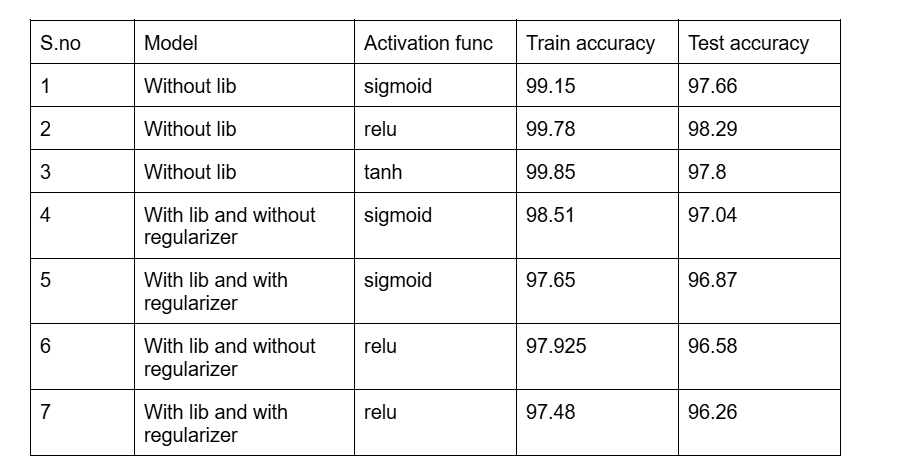